In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import plotly.offline as py
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import requests
import json
import os

#Initiate plotly
import plotly
plotly.offline.init_notebook_mode()

I want to look at how PHRMA spending leading up to the 2018 midterms is correlated with potential interests, including opioid overdose, marijuana use and regulations. We'll start by looking for a potential correlation with opioid death rates and absolute number of deaths.

Overdose rates and totals from the CDC data portal. Citation as follows:

Centers for Disease Control and Prevention, National Center for Health Statistics. Multiple Cause of Death 1999-2016 on CDC WONDER Online Database, released December, 2017. Data are from the Multiple Cause of Death Files, 1999-2016, as compiled from data provided by the 57 vital statistics jurisdictions through the Vital Statistics Cooperative Program. Accessed at http://wonder.cdc.gov/mcd-icd10.html on Jan 4, 2018 4:27:00 PM

In [2]:
#Loading in crude death rates by county, state for each year
years = [2010,2011,2012,2013,2014,2015,2016]
overdose_by_county = None
overdose_by_state = None
for year in years:
    #Find break line for TSV data in each file
    state_index = -1
    with open('data/overdoses/states/{yr}_crude_death_rates.tsv'.format(yr=year), 'r') as f:
        index = 0
        for line in f:
            if "---" in line:
                state_index = index
                break
            else:
                index += 1
                
    county_index = -1
    with open('data/overdoses/counties/{yr}_crude_death_rates.tsv'.format(yr=year), 'r') as f:
        index = 0
        for line in f:
            if "---" in line:
                county_index = index
                break
            else:
                index += 1
    
    #Load in overdoses for that year
    overdose_by_county_year = pd.read_csv('data/overdoses/counties/{yr}_crude_death_rates.tsv'.format(yr=year),
                                          delimiter='\t')[:county_index - 1]
    overdose_by_state_year = pd.read_csv('data/overdoses/states/{yr}_crude_death_rates.tsv'.format(yr=year),
                                         delimiter='\t')[:state_index - 1]

    #Add column indicating the year
    yearCol = pd.DataFrame({'Year': [year for i in range(len(overdose_by_county_year))]})
    overdose_by_county_year = overdose_by_county_year.join(yearCol)
    yearCol = pd.DataFrame({'Year': [year for i in range(len(overdose_by_state_year))]})
    overdose_by_state_year = overdose_by_state_year.join(yearCol)
    
    #Append to master list  
    if overdose_by_county is None or overdose_by_state is None:
        overdose_by_county = overdose_by_county_year
        overdose_by_state = overdose_by_state_year
    else:
        overdose_by_county = pd.concat([overdose_by_county,overdose_by_county_year], axis=0)
        overdose_by_state = pd.concat([overdose_by_state,overdose_by_state_year], axis=0)

In [3]:
overdose_by_county

Notes      State  State Code                  County  County Code  \
0      NaN    Alabama         1.0      Autauga County, AL       1001.0   
1      NaN    Alabama         1.0      Baldwin County, AL       1003.0   
2      NaN    Alabama         1.0      Barbour County, AL       1005.0   
3      NaN    Alabama         1.0         Bibb County, AL       1007.0   
4      NaN    Alabama         1.0       Blount County, AL       1009.0   
5      NaN    Alabama         1.0      Bullock County, AL       1011.0   
6      NaN    Alabama         1.0       Butler County, AL       1013.0   
7      NaN    Alabama         1.0      Calhoun County, AL       1015.0   
8      NaN    Alabama         1.0     Chambers County, AL       1017.0   
9      NaN    Alabama         1.0     Cherokee County, AL       1019.0   
10     NaN    Alabama         1.0      Chilton County, AL       1021.0   
11     NaN    Alabama         1.0      Choctaw County, AL       1023.0   
12     NaN    Alabama         1.0       Clarke County, AL       1025.0   
13     NaN    Alabama         1.0         Clay County, AL       1027.0   
14     NaN    Alabama         1.0     Cleburne County, AL       1029.0   
15     NaN    Alabama         1.0       Coffee County, AL       1031.0   
16     NaN    Alabama         1.0      Colbert County, AL       1033.0   
17     NaN    Alabama         1.0      Conecuh County, AL       1035.0   
18     NaN    Alabama         1.0        Coosa County, AL       1037.0   
19     NaN    Alabama         1.0    Covington County, AL       1039.0   
20     NaN    Alabama         1.0     Crenshaw County, AL       1041.0   
21     NaN    Alabama         1.0      Cullman County, AL       1043.0   
22     NaN    Alabama         1.0         Dale County, AL       1045.0   
23     NaN    Alabama         1.0       Dallas County, AL       1047.0   
24     NaN    Alabama         1.0       DeKalb County, AL       1049.0   
25     NaN    Alabama         1.0       Elmore County, AL       1051.0   
26     NaN    Alabama         1.0     Escambia County, AL       1053.0   
27     NaN    Alabama         1.0       Etowah County, AL       1055.0   
28     NaN    Alabama         1.0      Fayette County, AL       1057.0   
29     NaN    Alabama         1.0     Franklin County, AL       1059.0   
...    ...        ...         ...                     ...          ...   
3117   NaN  Wisconsin        55.0     Washburn County, WI      55129.0   
3118   NaN  Wisconsin        55.0   Washington County, WI      55131.0   
3119   NaN  Wisconsin        55.0     Waukesha County, WI      55133.0   
3120   NaN  Wisconsin        55.0      Waupaca County, WI      55135.0   
3121   NaN  Wisconsin        55.0     Waushara County, WI      55137.0   
3122   NaN  Wisconsin        55.0    Winnebago County, WI      55139.0   
3123   NaN  Wisconsin        55.0         Wood County, WI      55141.0   
3124   NaN    Wyoming        56.0       Albany County, WY      56001.0   
3125   NaN    Wyoming        56.0     Big Horn County, WY      56003.0   
3126   NaN    Wyoming        56.0     Campbell County, WY      56005.0   
3127   NaN    Wyoming        56.0       Carbon County, WY      56007.0   
3128   NaN    Wyoming        56.0     Converse County, WY      56009.0   
3129   NaN    Wyoming        56.0        Crook County, WY      56011.0   
3130   NaN    Wyoming        56.0      Fremont County, WY      56013.0   
3131   NaN    Wyoming        56.0       Goshen County, WY      56015.0   
3132   NaN    Wyoming        56.0  Hot Springs County, WY      56017.0   
3133   NaN    Wyoming        56.0      Johnson County, WY      56019.0   
3134   NaN    Wyoming        56.0      Laramie County, WY      56021.0   
3135   NaN    Wyoming        56.0      Lincoln County, WY      56023.0   
3136   NaN    Wyoming        56.0      Natrona County, WY      56025.0   
3137   NaN    Wyoming        56.0     Niobrara County, WY      56027.0   
3138   NaN    Wyoming        56.0         Park County, WY      56029.0   
3139   Na

How many counties total have suppressed or unreliable data?

In [4]:
print(len(overdose_by_county.loc[overdose_by_county['Year'] == 2016])) #Total county reports from 2016
len( #Total counties with unreliable or suppressed data
        overdose_by_county.loc[
            (overdose_by_county['Year'] == 2016) & (
                (overdose_by_county['Deaths'].str.match('Unreliable')) |
                (overdose_by_county['Crude Rate'].str.match('Unreliable')) |
                (overdose_by_county['Age Adjusted Rate'].str.match('Unreliable')) |
                (overdose_by_county['Deaths'].str.match('Suppressed')) |
                (overdose_by_county['Crude Rate'].str.match('Suppressed')) |
                (overdose_by_county['Age Adjusted Rate'].str.match('Suppressed'))
            )
        ]
   )

3147


2719

So, problem. For 2016, there are only 428 counties with data that isn't suppressed or unreliable; if we remove counties that didn't report at all too, that drops to 423.

The question then is why 2,719 counties in the US have unreliable or suppressed data. From the CDC's website (http://bit.ly/2COBLjG):

Death rates based on counts of less than twenty (death count < 20) are flagged as "Unreliable". A death rate based on fewer than 20 deaths has a relative standard error (RSE(R)) of 23 percent or more. A RES(R) of 23 percent is considered statistically unreliable.
...
The term "Suppressed" replaces sub-national death counts, births counts, death rates and associated confidence intervals and standard errors, as well as corresponding population figures, when the figure represents zero to nine (0-9) persons.

We're going to need to figure out how significant those counties that aren't reporting really are. We can do that by assuming that the number of people who died from an overdose in that county is the maximum number to come under the 'unreliable' value (19), check that against the population of the county, calculate deaths per 100,000 and compare that against the average across all counties. Any counties that have a value less than a standard deviation out from the all-county average (based on available data) are inconclusive, all that are at least a full stddev less can be approximated to be at the minimum value threshold (e.g. they'll be colored white on the map).

**TODO: see if we can parse it out like I discuss above. We're going to skip the chloropleth map in the meantime.**

In [5]:
#Sort states by rate of overdose
overdose_by_state

Notes                 State  State Code  Deaths  Population Crude Rate  \
0    NaN               Alabama         1.0   187.0   4779736.0        3.9   
1    NaN                Alaska         2.0    62.0    710231.0        8.7   
2    NaN               Arizona         4.0   626.0   6392017.0        9.8   
3    NaN              Arkansas         5.0   189.0   2915918.0        6.5   
4    NaN            California         6.0  1929.0  37253956.0        5.2   
5    NaN              Colorado         8.0   304.0   5029196.0        6.0   
6    NaN           Connecticut         9.0   223.0   3574097.0        6.2   
7    NaN              Delaware        10.0   103.0    897934.0       11.5   
8    NaN  District of Columbia        11.0    34.0    601723.0        5.7   
9    NaN               Florida        12.0  1674.0  18801310.0        8.9   
10   NaN               Georgia        13.0   534.0   9687653.0        5.5   
11   NaN                Hawaii        15.0    74.0   1360301.0        5.4   
12   NaN                 Idaho        16.0    79.0   1567582.0        5.0   
13   NaN              Illinois        17.0   867.0  12830632.0        6.8   
14   NaN               Indiana        18.0   289.0   6483802.0        4.5   
15   NaN                  Iowa        19.0   147.0   3046355.0        4.8   
16   NaN                Kansas        20.0   104.0   2853118.0        3.6   
17   NaN              Kentucky        21.0   591.0   4339367.0       13.6   
18   NaN             Louisiana        22.0   123.0   4533372.0        2.7   
19   NaN                 Maine        23.0    90.0   1328361.0        6.8   
20   NaN              Maryland        24.0   509.0   5773552.0        8.8   
21   NaN         Massachusetts        25.0   555.0   6547629.0        8.5   
22   NaN              Michigan        26.0   695.0   9883640.0        7.0   
23   NaN             Minnesota        27.0   235.0   5303925.0        4.4   
24   NaN           Mississippi        28.0   100.0   2967297.0        3.4   
25   NaN              Missouri        29.0   599.0   5988927.0       10.0   
26   NaN               Montana        30.0    54.0    989415.0        5.5   
27   NaN              Nebraska        31.0    58.0   1826341.0        3.2   
28   NaN                Nevada        32.0   439.0   2700551.0       16.3   
29   NaN         New Hampshire        33.0   116.0   1316470.0        8.8   
..   ...                   ...         ...     ...         ...        ...   
21   NaN         Massachusetts        25.0  1990.0   6811779.0       29.2   
22   NaN              Michigan        26.0  1762.0   9928300.0       17.7   
23   NaN             Minnesota        27.0   396.0   5519952.0        7.2   
24   NaN           Mississippi        28.0   180.0   2988726.0          6   
25   NaN              Missouri        29.0   914.0   6093000.0         15   
26   NaN               Montana        30.0    42.0   1042520.0          4   
27   NaN              Nebraska        31.0    44.0   1907116.0        2.3   
28   NaN                Nevada        32.0   408.0   2940058.0       13.9   
29   NaN         New Hampshire        33.0   437.0   1334795.0       32.7   
30   NaN            New Jersey        34.0  1409.0   8944469.0       15.8   
31   NaN            New Mexico        35.0   349.0   2081015.0       16.8   
32   NaN              New York        36.0  3009.0  19745289.0       15.2   
33   NaN        North Carolina        37.0  1506.0  10146788.0       14.8   
34   NaN          North Dakota        38.0    54.0    757952.0        7.1   
35   NaN                  Ohio        39.0  3613.0  11614373.0       31.1   
36   NaN              Oklahoma        40.0   444.0   3923561.0       11.3   
37   NaN                Oregon        41.0   312.0   4093465.0        7.6   
38   NaN          Pennsylvania        42.0  2235.0  12784227.0       17.5   
39   NaN          Rhode Island        44.0   279.0   1056426.0       26.4   
40   NaN        South Carolina        45.0   628.0   4961119.0       12.7   

In [6]:
#Load US county GeoJSON data (pulled from eric.clst.org/tech/usgeojson/)
import codecs
# raw_geojson = requests.get('http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_050_00_500k.json')
county_geo = json.load(codecs.open('data/geo/gz_2010_us_050_00_500k.json', 'r', encoding='utf-8', errors='ignore'))
county_geo['features'][0]

{'geometry': {'coordinates': [[[-85.388717, 33.913044],
    [-85.380885, 33.873508],
    [-85.379455, 33.866291],
    [-85.377426, 33.856047],
    [-85.376403, 33.850656],
    [-85.364595, 33.788446],
    [-85.361844, 33.773951],
    [-85.360491, 33.767958],
    [-85.357402, 33.750104],
    [-85.355252, 33.739245],
    [-85.344054, 33.682684],
    [-85.342722, 33.675953],
    [-85.323792, 33.580339],
    [-85.31534, 33.537646],
    [-85.314994, 33.535898],
    [-85.314843, 33.534951],
    [-85.314091, 33.530218],
    [-85.313999, 33.529807],
    [-85.304439, 33.482884],
    [-85.308211, 33.481579],
    [-85.30925, 33.483137],
    [-85.314852, 33.487603],
    [-85.316028, 33.488267],
    [-85.320893, 33.488359],
    [-85.324856, 33.489161],
    [-85.331061, 33.491014],
    [-85.33828, 33.4947],
    [-85.342544, 33.495961],
    [-85.344923, 33.497608],
    [-85.346705, 33.501148],
    [-85.349958, 33.501216],
    [-85.351594, 33.4996],
    [-85.354491, 33.498866],
    [-85.352576, 33.494

In [7]:
#Replace 'Unreliable', 'Suppressed with NaN (Unreliable represents)
overdose_by_county = overdose_by_county.replace('Unreliable', np.nan)
overdose_by_state = overdose_by_state.replace('Unreliable', np.nan)
overdose_by_county = overdose_by_county.replace('Suppressed', np.nan)
overdose_by_state = overdose_by_state.replace('Suppressed', np.nan)

#Pull out missing county reports
missing_value_counties = overdose_by_county.loc[
                        (overdose_by_county['Deaths'].str.match('Missing')) |
                        (overdose_by_county['Crude Rate'].str.match('Missing')) |
                        (overdose_by_county['Age Adjusted Rate'].str.match('Missing'))
                      ]

#Purge missing counties from the main table
overdose_by_county = overdose_by_county.drop(
        overdose_by_county[
            (overdose_by_county['Deaths'].str.match('Missing')) |
            (overdose_by_county['Crude Rate'].str.match('Missing')) |
            (overdose_by_county['Age Adjusted Rate'].str.match('Missing'))        
        ].index,
        inplace=False)

#Change types of values to float
overdose_by_state['Age Adjusted Rate'] = pd.to_numeric(overdose_by_state['Age Adjusted Rate'])
overdose_by_state['Year'] = pd.to_numeric(overdose_by_state['Year'])
overdose_by_county['Age Adjusted Rate'] = pd.to_numeric(overdose_by_county['Age Adjusted Rate'])
overdose_by_county['County Code'] = pd.to_numeric(overdose_by_county['County Code'])


In [8]:
#State-level overdose statistics
overdose_by_state.describe()

State Code       Deaths    Population  Age Adjusted Rate         Year
count  356.000000   356.000000  3.560000e+02         353.000000   357.000000
mean    28.935393   550.780899  6.216528e+06          10.137110  2013.008403
std     15.713591   558.080652  6.990472e+06           6.314536     2.004892
min      1.000000    10.000000  5.636260e+05           2.200000  2010.000000
25%     16.000000   133.000000  1.676088e+06           5.700000  2011.000000
50%     29.000000   407.500000  4.404376e+06           8.600000  2013.000000
75%     42.000000   716.250000  6.905527e+06          12.600000  2015.000000
max     56.000000  3613.000000  3.925002e+07          43.400000  2016.000000

In [9]:
#County-level overdose statistics
overdose_by_county.describe()

State Code   County Code  Age Adjusted Rate          Year
count  22019.000000  21917.000000        2251.000000  22021.000000
mean      30.340797  30450.580554          15.714083   2013.000000
std       15.085430  15101.162985          13.764418      2.000045
min        1.000000   1001.000000           1.600000   2010.000000
25%       19.000000  19005.000000           7.700000   2011.000000
50%       29.000000  29183.000000          12.000000   2013.000000
75%       45.000000  45083.000000          18.900000   2015.000000
max       56.000000  56045.000000         137.500000   2016.000000

In [10]:
#Select all 2016 county data, filter out NaNs
filtered_overdose_by_county = overdose_by_county.loc[
    (overdose_by_county['Age Adjusted Rate'].notnull()) &
    (overdose_by_county['Year'] == 2016)
]
lowest_overdose_rate = min(filtered_overdose_by_county['Age Adjusted Rate'])
highest_overdose_rate = max(filtered_overdose_by_county['Age Adjusted Rate'])


#Create scalar-to-color mapper for age adjusted overdose rates
reds = cm = plt.get_cmap('Reds') 
cNorm  = colors.Normalize(vmin=lowest_overdose_rate,
                          vmax=highest_overdose_rate)
overdose_color_mapper = cmx.ScalarMappable(norm=cNorm, cmap=reds)

#Assign colors for overdose rates
chloropleth_layers = []
counter = 0
not_counter = 0
for feature in county_geo['features']:
    #Extract county's row from dataframe
    state_code = feature['properties']['STATE']
    county_code = feature['properties']['COUNTY']
    row = overdose_by_county.loc[
        (overdose_by_county['County Code'] == float(state_code + county_code)) &
        (overdose_by_county['Year'] == 2016)
    ]
    if row.empty:
        color = (255,255,255,0)
    else:
#         print(row['Age Adjusted Rate'])
        color = overdose_color_mapper.to_rgba(row['Age Adjusted Rate'])
        
print(counter)
print(not_counter)

#         dict(
#             sourcetype = 'geojson',
#             source = {"type": "FeatureCollection", "features" : [feature]},
#             type = 'fill',
#             color = overdose_color_mapper.to_rgba(val)
#         )
#             for feature in county_geo['features']
# = [overdose_color_mapper.to_rgba(val)
#                  for val in filtered_overdose_by_county['Age Adjusted Rate']]

0
0


In [11]:
#Plotting all counties in the US according to overdose rates,
#Counties with unreliable data represented as greyed-out
MAPBOX_ACCESS_TOKEN = os.environ['MAPBOX_ACCESS_TOKEN']
chloropleth_data = go.Data([
    go.Scattermapbox(
        lat=['45.5017'],
        lon=['-73.5673'],
        mode='markers',
    )
])
chloropleth_layout = go.Layout(
    height=600,
    autosize=True,
    hovermode='closest',
    mapbox=dict(
        layers=chloropleth_layers, #Empty until we fix the cell above^^
        accesstoken=MAPBOX_ACCESS_TOKEN,
        bearing=0,
        center=dict(
            lat=37.09,
            lon=-95.91
        ),
        pitch=0,
        zoom=3,
        style='light'
    ),
)
fig = dict(data=chloropleth_data,layout=chloropleth_layout)
py.iplot(fig, filename='county-level-choropleths-python')

**The chloropleth map is taking *lots* of time, just going to have to come back to this one.**

OK, so let's first see if we can establish that big pharma is targeting Congressional races by the year. If we can do that, it may be possible to demonstrate that they're also shifting their money year after year depending on *where* the deaths are occurring.

Chances are that we're not going to be able to use the OpenSecrets API for this since it rate-limits all method calls at 200 per day, which really isn't good enough to deal with ~30,000 candidates spread over five election cycles.

Instead we're going to try to reproduce the `candIndByInd` API method using the bulk data dumps.

All campaign data acquired through [OpenSecrets.org](https://www.opensecrets.org/open-data/bulk-data) bulk data dumps.

In [12]:
#Loading in candidate, committee, pac-to-pac, pac-to-candidate data
#(had to re-save cmte{cycle}.txt files in utf-8 encoding w/ Sublime)
candidates = None
committees = None
pac_to_pac = None
pac_to_candidate = None
cycles = [2010,2012,2014,2016,2018]
for cycle in cycles:
    #Candidates
    with open('data/opensecrets/CampaignFin{cycle}/cands{cycle}.txt'.format(cycle=cycle-2000), 'r') as f:
        candidates_year = pd.read_csv(f,quotechar='|',
                                      header=None,
                                      names=[
                                          'Cycle',
                                          'FECCandID',
                                          'CID',
                                          'FirstLastP',
                                          'Party',
                                          'DistIDRunFor',
                                          'DistIDCurr',
                                          'CurrCand',
                                          'CycleCand',
                                          'CRPICO',
                                          'RecipCode',
                                          'NoPacs'
                                      ]
                                     )
        if candidates is None:
            candidates = candidates_year
        else:
            candidates = pd.concat([candidates, candidates_year], axis=0)
         
    #Committees
    with open('data/opensecrets/CampaignFin{cycle}/cmtes{cycle}.txt'.format(cycle=cycle-2000), 'r') as f:
        committees_year = pd.read_csv(f,
                                      header=None,
                                      quotechar='|',
                                      names=[
                                          'Cycle',
                                          'CmteID',
                                          'PACShort',
                                          'Affiliate',
                                          'Ultorg',
                                          'RecipID',
                                          'RecipCode',
                                          'FECCandID',
                                          'Party',
                                          'PrimCode',
                                          'Source',
                                          'Sensitive',
                                          'Foreign',
                                          'Active'
                                      ]
                                     )
        if committees is None:
            committees = committees_year
        else:
            committees = pd.concat([committees, committees_year], axis=0)

    #PAC-to-candidate
    with open('data/opensecrets/CampaignFin{cycle}/pacs{cycle}.txt'.format(cycle=cycle-2000), 'r') as f:
        pac_to_candidate_year = pd.read_csv(f,
                                      quotechar='|',
                                      header=None,
                                      low_memory=False,
                                      names=[
                                          'Cycle',
                                          'FECRecNo',
                                          'PACID',
                                          'CID',
                                          'Amount',
                                          'Date',
                                          'RealCode',
                                          'Type',
                                          'DI',
                                          'FECCandID'
                                      ]
                                     )
        if pac_to_candidate is None:
            pac_to_candidate = pac_to_candidate_year
        else:
            pac_to_candidate = pd.concat([pac_to_candidate, pac_to_candidate_year], axis=0)
            
#     #PAC-to-PAC
    with open('data/opensecrets/CampaignFin{cycle}/pac_other{cycle}.txt'.format(cycle=cycle-2000), 'r') as f:
        pac_to_pac_year = pd.read_csv(f,
                                      header=None,
                                      quotechar='|',
                                      low_memory=False,
                                      names=[
                                          'Cycle',
                                          'FECRecNo',
                                          'Filerid',
                                          'DonorCmte',
                                          'ContribLendTrans',
                                          'City',
                                          'State',
                                          'Zip',
                                          'FECOccEmp',
                                          'Primcode',
                                          'Date',
                                          'Amount',
                                          'RecipID',
                                          'Party',
                                          'Otherid',
                                          'RecipCode',
                                          'RecipPrimcode',
                                          'Amend',
                                          'Report',
                                          'PG',
                                          'Microfilm',
                                          'Type',
                                          'RealCode',
                                          'Source'
                                      ]
                                     )
        if pac_to_pac is None:
            pac_to_pac = pac_to_pac_year
        else:
            pac_to_pac = pd.concat([pac_to_pac, pac_to_pac_year], axis=0)

In [13]:
candidates

Cycle  FECCandID        CID                       FirstLastP Party  \
0      2010  H0CT01100  N00033186            Daniel J Stepanek (3)     3   
1      2010  H0CT02181  N00033187             Muriel P Bianchi (3)     3   
2      2010  H0CT04187  N00033189              Eugene Flanagan (3)     3   
3      2010  H0CT05184  N00033190                  Elmon Smith (3)     3   
4      2010  S2FL00243  N00029296                William Burns (3)     3   
5      2010  H8CA37285  N00030571                  June Pouesi (R)     R   
6      2010  S8ID00068  N00027743               Robert Vasquez (R)     R   
7      2010  H8AR03058  N00030401          Abel Noah Tomlinson (3)     3   
8      2010  P80003536  N00028980       William Charles Hughes (D)     D   
9      2010  H4AZ08058  N00027167                  Eva K Bacal (D)     D   
10     2010  H6CA05203  N00027460            Lara Ruth Shapiro (D)     D   
11     2010  H6NJ11112  N00028296                     Tom Wyka (D)     D   
12     2010  S4GA11053  N00002556                  Mac Collins (R)     R   
13     2010  H4VA08109  N00026241           Melissa Joy Martin (R)     R   
14     2010  S4PA00154  N00007606                Gene Douglass (R)     R   
15     2010  S4MO00169  N00026325                 Nancy Farmer (D)     D   
16     2010  H4AZ08017  N00026923                   Randy Graf (R)     R   
17     2010  S4IA00046  N00026997                 Arthur Small (D)     D   
18     2010  P80005721  N00027694             Claire McCaskill (D)     D   
19     2010  P80005291  N00014497                Haley Barbour (U)     U   
20     2010  S0CT00235  N00033147                  Dave Olszta (3)     3   
21     2010  S0CT00243  N00033148                  Jay J Giles (3)     3   
22     2010  S0CT00268  N00033149                John Traceski (3)     3   
23     2010  S0CT00284  N00033151                  Todd Vachon (3)     3   
24     2010  S0ID00131  N00033152      Frederick R Reinisch Jr (3)     3   
25     2010  S0IL00444  N00033153  Shon-Tiyon 'Santiago Horton (3)     3   
26     2010  S0IL00451  N00033154                  Avner Nagar (3)     3   
27     2010  S0IL00469  N00033155              Darren Raichart (3)     3   
28     2010  S0IL00477  N00033156               Lowell M Seida (3)     3   
29     2010  S0IL00485  N00033157                  Ina Pinkney (3)     3   
...     ...        ...        ...                              ...   ...   
5057   2018  H8TX32122  N00041213             George Rodriguez (D)     D   
5058   2018  H8UT03162  N00041214                     Brad Daw (R)     R   
5059   2018  H8UT03170  N00041215              Margaret Dayton (R)     R   
5060   2018  H8UT03188  N00041216             Deidre Henderson (R)     R   
5061   2018  H8UT03196  N00041217                 Tanner Ainge (R)     R   
5062   2018  H8UT03204  N00041218                 Faeiza Javed (D)     D   
5063   2018  H8UT03212  N00041219              Deborah Aldrich (R)     R   
5064   2018  H8UT03220  N00041220        Bringham Rhead Cottam (R)     R   
5065   2018  H8UT03238  N00041221                  John Curtis (R)     R   
5066   2018  H8UT03246  N00041222                    Paul Fife (R)     R   
5067   2018  H8UT03253  N00034218                 Chris Herrod (R)     R   
5068   2018  H8UT03261  N00040767                  Damian Kidd (R)     R   
5069   2018  H8UT03279  N00041225                  Keith Kuder (R)     R   
5070   2018  H8UT03287  N00041226                 Mike Leavitt (R)     R   
5071   2018  H8UT03295  N00041227                 Stewart Peay (R)     R   
5072   2018  H8UT03303  N00041228                    Shane Row (R)     R   
5073   2018  H8UT03311  N00041229            Jason Christensen (3)     3   
5074   2018  H8UT03329  N00041230               Aaron Heineman (3)     3   
5075   2018  H8UT03337  N00041227                 Stewart Peay (R)     R   
5076   2018  H8UT03345  N00041232                  Sean Whalen (I)     I   
5077   2018  H8UT04038  N00041233                   To

In [14]:
committees

Cycle     CmteID                                PACShort  \
0       2010  C00000042                     Illinois Tool Works   
1       2010  C00000059                          Hallmark Cards   
2       2010  C00000422                   American Medical Assn   
3       2010  C00000489                     Teamsters Local 886   
4       2010  C00000547                     Kansas Medical Assn   
5       2010  C00000638                    Indiana Medical Assn   
6       2010  C00000729                    American Dental Assn   
7       2010  C00000885          Painters & Allied Trades Union   
8       2010  C00000901          National Assn of Home Builders   
9       2010  C00000935  Democratic Congressional Campaign Cmte   
10      2010  C00000984                         US Telecom Assn   
11      2010  C00000992           Branch County Republican Cmte   
12      2010  C00001008               Louisiana Medical Society   
13      2010  C00001016              Carpenters & Joiners Union   
14      2010  C00001180                Michigan Medical Society   
15      2010  C00001198           American Hotel & Lodging Assn   
16      2010  C00001214                      Texas Medical Assn   
17      2010  C00001305            Republican Party of Virginia   
18      2010  C00001313           Republican Party of Minnesota   
19      2010  C00001347                     Hawaii Medical Assn   
20      2010  C00001388                Dairy Farmers of America   
21      2010  C00001420                   Missouri Medical Assn   
22      2010  C00001461                     Alaska Medical Assn   
23      2010  C00001636             United Transportation Union   
24      2010  C00001685                 Medical Assn of Georgia   
25      2010  C00001727                   Business Industry PAC   
26      2010  C00001743   International Longshoremens Assn 1814   
27      2010  C00001776                 New Mexico Medical Assn   
28      2010  C00001818                 Washington Medical Assn   
29      2010  C00001917   Wyoming State Democratic Central Cmte   
...      ...        ...                                     ...   
15317   2018  C90017047                                     NaN   
15318   2018  C90017054                                     NaN   
15319   2018  C90017062                                     NaN   
15320   2018  C90017070                                     NaN   
15321   2018  C90017088                                     NaN   
15322   2018  C90017096                                     NaN   
15323   2018  C90017104                                     NaN   
15324   2018  C90017112                                     NaN   
15325   2018  C90017120                                     NaN   
15326   2018  C90017138                                     NaN   
15327   2018  C90017146                                     NaN   
15328   2018  C90017153                                     NaN   
15329   2018  C90017161                                     NaN   
15330   2018  C90017179                                     NaN   
15331   2018  C90017187                                     NaN   
15332   2018  C90017195                                     NaN   
15333   2018  C90017203                                     NaN   
15334   2018  C90017211                                     NaN   
15335   2018  C90017229                                     NaN   
15336   2018  C90017237                                     NaN   
15337   2018  C90017245                                     NaN   
15338   2018  C90017252                      Better Georgia Inc   
15339   2018  C90017260                      Ellwood, Christi L   
15340   2018  C90017286                                     NaN   
15341   2018  C90017294                                 CLA Inc   
15342   2018  C90017302                  America First Policies   
15343   2018  C90017310                  Rosenzweig, Scott Alan   
15344   2018  C90017328                               

In [15]:
pac_to_candidate

Cycle             FECRecNo      PACID        CID  Amount        Date  \
0       2010  4060820101126893636  C00077321  N00032019    1000  04/22/2010   
1       2010  4121320101132796780  C00367920  N00003389    1000  09/29/2010   
2       2010  2080520091117296101  C00246421  N00004956     500  03/11/2009   
3       2010  4120920091121893616  C00027359  N00008619    3000  11/24/2009   
4       2010  4020820111135445349  C00100974  N00009699    1000  10/25/2010   
5       2010  4091320101129554233  C00004861  N00001746   -2500  08/05/2010   
6       2010  4060920101126939795  C00022343  N00009659    1000  04/26/2010   
7       2010  4033120111137940178  C00000042  N00031297    1000  12/09/2010   
8       2010  4081120101128287591  C00194126  N00024862    1000  06/22/2010   
9       2010  4071520101127485103  C00254268  N00027229    1000  06/28/2010   
10      2010  4072920091116760526  C00366013  N00001171    1000  06/25/2009   
11      2010  4011220111133600445  C00196246  N00026160   -5000  02/17/2010   
12      2010  4083020101129314239  C00158881  N00003528    2500  07/23/2010   
13      2010  4082620101129200187  C00118208  N00004426    1000  07/23/2010   
14      2010  4022420111136336414  C00366559  N00000860    1000  10/01/2010   
15      2010  4042920091114405403  C00257329  N00001604    2000  02/05/2009   
16      2010  4020120121150261023  C00431858  N00002171    1000  03/02/2009   
17      2010  4032420091113110583  C00007880  N00004719    1000  02/04/2009   
18      2010  4051020101126205358  C00142711  N00026314    1000  03/22/2010   
19      2010  4061720101127055636  C00374447  N00007876     250  05/27/2010   
20      2010  4071920101127543380  C00321158  N00004961     500  06/17/2010   
21      2010  4102020101130577287  C00445874  N00004291    1000  09/24/2010   
22      2010  4051120101126243046  C00081547  N00002593    1000  03/19/2010   
23      2010  4102820091120199507  C00002766  N00000781    2500  05/12/2009   
24      2010  4042320101125490333  C00001214  N00026686    1000  02/16/2010   
25      2010  4042820101125876838  C00437053  N00030769    1000  02/17/2010   
26      2010  4050820091114778048  C00329425  N00001604    1000  04/17/2009   
27      2010  4082520091117683870  C00402784  N00005195    1000  06/11/2009   
28      2010  4120320091121818389  C00197095  N00027891    1000  09/25/2009   
29      2010  4111620101131478187  C00109017  N00002260   -1000  09/30/2010   
...      ...                  ...        ...        ...     ...         ...   
67547   2018  4071720171418934957  C00574921  N00026710    1000  06/05/2017   
67548   2018  4070720171418723199  C00377960  N00031647    2500  02/15/2017   
67549   2018  4080420171442585122  C00010082  N00029139    1000  03/30/2017   
67550   2018  4082120171447713183  C00002881  N00035007    1000  07/17/2017   
67551   2018  4062020171410218061  C00341602  N00034784    1000  05/17/2017   
67552   2018  4081820171447631824  C00030718  N00034068    1000  07/21/2017   
67553   2018  4050320171400818581  C00034157  N00033101    1000  04/20/2017   
67554   2018  4021420171370711909  C00078451  N00026790    1500  01/18/2017   
67555   2018  4071420171418893361  C00483677  N00033630    1000  05/18/2017   
67556   2018  4050420171400827585  C00024869  N00035504    1000  04/21/2017   
67557   2018  4080720171442794987  C00536573  N00027239    1000  07/26/2017   
67558   2018  4062020171410218747  C00326389  N00036403    1000  05/08/2017   
67559   2018  4080720171442789412  C00384354  N00004614    2000  05/23/2017   
67560   2018  4041120171398487302  C00227744  N00035307    2000  03/09/2017   
67561   2018  4072020171426289680  C00499400  N00031177    1000  04/27/2017   
67562   2018  4072620171433285280  C00120030  N00004403    1000  06/06/2017   
67563   2018  4072020171426310556  C00522094  N00009573    1500  06/19/2017   
67564   2018  4061920171410171776  C00281162  N00027694    4500  02/10/2017   
67565   2018  4080220171442427390  C00425975  N00001311  

In [16]:
pac_to_pac

Cycle             FECRecNo    Filerid  \
0       2010  1010420100003812861  C00032334   
1       2010  1010420100003812863  C00068692   
2       2010  1010420100003812867  C00114439   
3       2010  1010420100003812868  C00114439   
4       2010  1010420100003812869  C00005801   
5       2010  1010420100003812870  C00114439   
6       2010  1010420100003812871  C00167015   
7       2010  1010420100003812872  C00461707   
8       2010  1010420100003812873  C00461707   
9       2010  1010420110005103421  C00346312   
10      2010  1010420110005103423  C00346312   
11      2010  1010420110005103424  C00346312   
12      2010  1010420110005103425  C00346312   
13      2010  1010420110005103426  C00346312   
14      2010  1010420110005104064  C00068353   
15      2010  1010420110005106314  C00068353   
16      2010  1010620100003819342  C00279455   
17      2010  1010620100003819343  C00279455   
18      2010  1010620100003819351  C00279455   
19      2010  1010620100003819352  C00279455   
20      2010  1010620100003819403  C00279455   
21      2010  1010620100003819407  C00279455   
22      2010  1010620100003819415  C00279455   
23      2010  1010620100003819416  C00279455   
24      2010  1010620100003819420  C00279455   
25      2010  1010620100003819434  C00279455   
26      2010  1010620100003819438  C00279455   
27      2010  1010620100003819445  C00279455   
28      2010  1010620100003820214  C00363770   
29      2010  1010620100003820215  C00271338   
...      ...                  ...        ...   
43354   2018  4090820171450351948  C00000059   
43355   2018  4090820171455364044  C00427930   
43356   2018  4090820171455365718  C00433060   
43357   2018  4090820171455365722  C00165159   
43358   2018  4090820171455365723  C00165159   
43359   2018  4090820171455365724  C00165159   
43360   2018  4090820171455367846  C00412791   
43361   2018  4090820171455367847  C00412791   
43362   2018  4090820171455367848  C00412791   
43363   2018  4090820171455367849  C00412791   
43364   2018  4090820171455367850  C00412791   
43365   2018  4090820171455367851  C00412791   
43366   2018  4090820171455367852  C00412791   
43367   2018  4090820171455367853  C00412791   
43368   2018  4090820171455368328  C00545467   
43369   2018  4090820171455368390  C00545467   
43370   2018  4090820171455368398  C00545467   
43371   2018  4090820171455368399  C00545467   
43372   2018  4090820171455368400  C00545467   
43373   2018  4090820171455368457  C00545467   
43374   2018  4090820171455368473  C00545467   
43375   2018  4090820171455368520  C00489112   
43376   2018  4090820171455368806  C00383869   
43377   2018  4090820171455368807  C00383869   
43378   2018  4090820171455368808  C00383869   
43379   2018  4090820171455368809  C00383869   
43380   2018  4090820171455368810  C00383869   
43381   2018  4090920171455368994  C00634832   
43382   2018  4090920171455368995  C00634832   
43383   2018  4090920171455368996  C00634832   

                                            DonorCmte  \
0                           Adrian Smith for Congress   
1                                       FedEx Express   
2                                   DNC Services Corp   
3                                   DNC Services Corp   
4             Virginia Sixth District Republican Cmte   
5                                   DNC Services Corp   
6                     American Federation of Teachers   
7                                              HISPAC   
8                                              HISPAC   
9                                  Friends of Schumer   
10                                 Friends of Schumer   
11                                 Friends of Schumer   
12                                 Friends of Schumer   
13                                 Friends of Schumer   
14                          Leahy for US Senator Cmte   
15                                Vermont Senate 2010   
16                        AstraZeneca Pharmaceuticals   
17  

In [17]:
pac_to_pac.describe()

Cycle      FECRecNo        Amount     Microfilm
count  603196.000000  6.031960e+05  6.031960e+05  6.031960e+05
mean     2013.588339  3.853912e+18  1.736217e+04  6.501979e+16
std         2.466820  6.932146e+17  1.913517e+05  9.424355e+16
min      2010.000000  1.010120e+18 -1.000000e+06  1.002001e+10
25%      2012.000000  4.030420e+18  1.400000e+03  1.295138e+10
50%      2014.000000  4.061620e+18  3.000000e+03  1.495238e+10
75%      2016.000000  4.090920e+18  5.000000e+03  2.016013e+17
max      2018.000000  4.123120e+18  2.517721e+07  2.017091e+17

All data for candidates, committees, PAC-to-PAC transactions and PAC-to-candidate transactions is now loaded. We'll now attempt to extract the contributions from the pharmaceutical industry during 2016 to various candidates, then tie those candidates back to their home states, and finally the overdose rates. The flow will look like this:

**STATE --> CANDIDATE --> PHARMA CONTRIBUTIONS --> Aggregate all state contributions **

**STATE --> OVERDOSE RATE**

We can store these values in a nested dictionary for easy retrieval by year and state.

In [18]:
#Select all rows from 2016 (we'll revisit 2018 next year when there's more data available)
# cycle_pac_to_pac = pac_to_pac.loc[(pac_to_pac['State'].notnull()) & (pac_to_pac['Cycle'] == 2016)]

In [19]:
#Select all PAC-to-candidate contributions from 2016 with positive contribution amounts and pharma-related codes
PHARMACISTS_CODE='H1750'
PHARMA_MANUFACTURING_CODE='H4300'
PHARMA_WHOLESALE_CODE='H4400'
pharma_candidate_contributions = pac_to_candidate.loc[
        (pac_to_candidate['RealCode'] == PHARMACISTS_CODE) |
        (pac_to_candidate['RealCode'] == PHARMA_MANUFACTURING_CODE) |
        (pac_to_candidate['RealCode'] == PHARMA_WHOLESALE_CODE)
]
pharma_candidate_contributions

Cycle             FECRecNo      PACID        CID  Amount        Date  \
95      2010  4032820101124700312  C00199703  N00001811    2000  02/18/2010   
216     2010  4121320101132796357  C00279455  N00009775    2000  03/19/2010   
251     2010  1010620100003819430  C00279455  N00003875    2000  06/04/2009   
252     2010  4030820111137027581  C00030809  N00027462    1000  03/03/2009   
275     2010  4030820111137027805  C00030809  N00003545    1000  03/03/2009   
305     2010  4030920111137085896  C00030809  N00009828    2000  06/03/2009   
317     2010  4120220101132099950  C00468660  N00007335    1000  09/30/2010   
344     2010  4060220101126753019  C00016683  N00026160    1000  04/21/2010   
377     2010  4110920101131355230  C00420398  N00000153    1000  09/21/2010   
403     2010  4111720091121367001  C00040279  N00005329    1000  10/27/2009   
447     2010  4111720101131563967  C00251876  N00027503    1000  09/21/2010   
448     2010  4030220111136693199  C00433284  N00003535    1000  12/01/2010   
503     2010  4030820111137029070  C00030809  N00007584    3000  08/27/2009   
506     2010  4011220111133600030  C00400929  N00029412    1000  09/09/2010   
511     2010  4080420101128103149  C00040279  N00003682    5000  06/01/2010   
556     2010  4080420101128103262  C00281162  N00001725    1000  06/01/2010   
607     2010  4111720101131563975  C00251876  N00031593    2000  09/21/2010   
608     2010  4111920091121412597  C00016683  N00026171    1000  10/14/2009   
616     2010  4030920111137087106  C00030809  N00004961    2000  03/10/2010   
694     2010  4093020091118704627  C00199703  N00009922    1000  06/26/2009   
792     2010  4073120091117189203  C00292102  N00030655     500  02/17/2009   
852     2010  4110820101131298573  C00433284  N00013823   -1000  06/30/2010   
932     2010  4082520101129106356  C00108035  N00007232    2000  07/29/2010   
1025    2010  4121020101132486072  C00279455  N00024809    5000  09/24/2010   
1055    2010  4040920091113671686  C00251876  N00004403    1000  03/13/2009   
1142    2010  4110920101131355256  C00108035  N00007584    1000  09/07/2010   
1196    2010  4081420121160881509  C00332395  N00007419    1000  04/28/2009   
1213    2010  4011220111133600011  C00400929  N00005395    1500  09/21/2010   
1225    2010  4080320091117236635  C00281162  N00029901    2000  06/01/2009   
1241    2010  4022720121152414608  C00423236  N00000179     500  09/10/2010   
...      ...                  ...        ...        ...     ...         ...   
66704   2018  4060720171409484019  C00536573  N00031933    1000  05/12/2017   
66764   2018  4081020171446368343  C00400929  N00006263    1000  07/11/2017   
66824   2018  4041920171399930183  C00543835  N00009869    1700  03/13/2017   
66836   2018  4080320171442500433  C00144345  N00002577    1000  06/19/2017   
66849   2018  4061320171409673576  C00016683  N00033495    2500  05/15/2017   
66860   2018  4080120171442398400  C00558452  N00033549    1000  06/07/2017   
66872   2018  4061320171409645827  C00391086  N00006460    5000  05/12/2017   
66902   2018  4041820171398921250  C00424838  N00037422    1000  03/28/2017   
66916   2018  4060920171409548561  C00108035  N00027503    3000  05/24/2017   
66949   2018  4072520171432854932  C00251876  N00029277    2500  06/22/2017   
66972   2018  4072520171432854864  C00251876  N00024992    2500  06/02/2017   
66975   2018  4071420171418886171  C00021972  N00031502     500  06/24/2017   
67045   2018  4041820171398892210  C00400929  N00033782    2500  03/28/2017   
67047   2018  4041820171398921270  C00424838  N00002593    1000  03/22/2017   
67065   2018  4042020171400026489  C00097485  N00029675    1000  03/21/2017   
67074   2018  4071820171423057811  C00082792  N00035820    1000  06/28/2017   
67080   2018  4080320171442500447  C00144345  N00026586    1000  02/02/2017   
67100   2018  4071720171418920805  C00400929  N00030768    1000  06/26/2017   
67126   2018  4022220171371920525  C00251876  N00037442  

In [20]:
pharma_candidate_contributions.describe()

Cycle        Amount
count  32348.000000  32348.000000
mean    2013.450352   1646.527451
std        2.511809   1220.562962
min     2010.000000  -5000.000000
25%     2012.000000   1000.000000
50%     2014.000000   1000.000000
75%     2016.000000   2500.000000
max     2018.000000   5000.000000

In [21]:
pharma_pac_contributions = pac_to_pac.loc[
        (pac_to_pac['RealCode'] == PHARMACISTS_CODE) |
        (pac_to_pac['RealCode'] == PHARMA_MANUFACTURING_CODE) |
        (pac_to_pac['RealCode'] == PHARMA_WHOLESALE_CODE)
]
pharma_pac_contributions.nlargest(50, 'Amount')

Cycle             FECRecNo    Filerid  \
15943    2012  4011720131178964571  C00040279   
25634    2012  4020720131180852637  C00536573   
80354    2016  4060920151244385654  C00460238   
83227    2016  4061920151245804410  C00097485   
16379    2016  4011220171367454772  C00040279   
92768    2010  4091720101129667466  C00381475   
92821    2010  4092020101129683389  C00040279   
46880    2014  4041720141211853200  C00407460   
43198    2010  4032220101124621846  C00016683   
46143    2010  4033120101124898810  C00115303   
146509   2016  4112320161351229711  C00215236   
148577   2016  4112820161354716963  C00144345   
47988    2010  4041220101125139501  C00108290   
65091    2010  4061420101126960335  C00097485   
50037    2012  4042020111138209104  C00072769   
55166    2012  4050520111139686317  C00199257   
91254    2016  4071420161306603307  C00595710   
8249     2016  2052620161293506644  C00027466   
62963    2016  4042020161283570597  C00016683   
147548   2016  4112620161351694276  C00016683   
147581   2016  4112620161351698493  C00016683   
160736   2016  4122720161358077774  C00619437   
68127    2012  4062220111141036036  C00072769   
68523    2012  4062420111141078211  C00199257   
18545    2018  4060920171409550912  C00365072   
26915    2018  4071720171418942684  C00568162   
33131    2016  4020820161262281344  C00569152   
106121   2016  4073120151248144966  C00463539   
111743   2012  4102520121168544138  C00427021   
1092     2016  1030420160018438660  C00042366   
18699    2016  4012020161260760095  C00016683   
18588    2018  4061220171409628026  C00495028   
44273    2016  4030220171373706655  C00075820   
127963   2016  4101720161343819927  C00365072   
133485   2016  4102420161344572842  C00619437   
147981   2016  4112820161354302606  C00615203   
924      2010  1031220100004005528  C00042366   
983      2010  1031220100004006139  C00042366   
990      2010  1031220100004006146  C00042366   
1950     2010  1040520120009639615  C00042366   
2040     2010  1040920100004047674  C00042366   
2061     2010  1040920100004047695  C00042366   
2077     2010  1040920100004047756  C00042366   
2268     2010  1041220100004067068  C00042366   
2514     2010  1041720100004093134  C00042366   
2620     2010  1042220100004122606  C00027466   
2621     2010  1042220100004122607  C00027466   
2658     2010  1042220100004122783  C00027466   
2804     2010  1050220110005747534  C00027466   
3052     2010  1050220110005772646  C00042366   

                                                DonorCmte  \
15943                                 Abbott Laboratories   
25634                                 Abbott Laboratories   
80354                              Cubist Pharmaceuticals   
83227                              Cubist Pharmaceuticals   
16379                                 Abbott Laboratories   
92768                          Solvay-Abbott Laboratories   
92821                          Solvay-Abbott Laboratories   
46880                          Millennium Pharmaceuticals   
43198                                               Wyeth   
46143                                               Wyeth   
146509                                 Sanofi-Pasteur Inc   
148577                                 Sanofi-Pasteur Inc   
47988                                Schering-Plough Corp   
65091                                Schering-Plough Corp   
50037                                   Hoffmann-La Roche   
55166                                   Hoffmann-La Roche   
91254   Pharmaceutical Research & Manufacturers of Ame...   
8249                                           Pfizer Inc   
62963                                          Pfizer Inc   
147548                                         Pfizer Inc   
147581                                         Pfizer Inc   
160736                                         Pfizer Inc   
68127                                   Hoffmann-La Roche   
68523                                   Hoff

In [22]:
pharma_pac_contributions.describe()

Cycle      FECRecNo         Amount     Microfilm
count  16761.000000  1.676100e+04   16761.000000  1.676100e+04
mean    2013.776266  3.960266e+18    3658.157389  6.892670e+16
std        2.492626  5.093876e+17    4709.106117  9.563801e+16
min     2010.000000  1.010120e+18  -15000.000000  1.002013e+10
25%     2012.000000  4.032220e+18    1500.000000  1.295224e+10
50%     2014.000000  4.061920e+18    2500.000000  1.496049e+10
75%     2016.000000  4.082620e+18    5000.000000  2.016022e+17
max     2018.000000  4.123020e+18  235400.000000  2.017081e+17

In [23]:
pharma_pac_contributions.loc[
    (pharma_pac_contributions['Cycle'] == 2016) &
    (pharma_pac_contributions['Amount'] > 0)
]['Amount'].sum()

18191112.0

In [24]:
pharma_candidate_contributions.loc[
    (pharma_candidate_contributions['Cycle'] == 2016) &
    (pharma_candidate_contributions['Amount'] > 0)
]['Amount'].sum()

14526602

Wow, just over 8,400 direct contributions totaling \$14.53 million from pharmacists, manufacturers and wholesalers during the 2016 election alone, and an additional \$18.19 million in committee contributions. Where are these contributions centered?

In [25]:
#Build dict of CIDs to amount received from pharma industry over all election cycles 2010-2018
year_to_cid_to_contributions = dict([
    (
        year,
        dict([(cid,0) for cid in pharma_candidate_contributions['CID']])
    ) for year in cycles])
for index, row in pharma_candidate_contributions.iterrows():
    if row['Amount'] > 0:
        year_to_cid_to_contributions[row['Cycle']][row['CID']] += row['Amount']
year_to_cid_to_contributions

{2010: {'N00000010': 1000,
  'N00000019': 0,
  'N00000036': 5000,
  'N00000078': 1500,
  'N00000133': 42500,
  'N00000143': 2000,
  'N00000153': 63500,
  'N00000179': 29500,
  'N00000226': 1000,
  'N00000245': 15500,
  'N00000267': 35500,
  'N00000270': 13000,
  'N00000275': 1000,
  'N00000280': 4000,
  'N00000286': 0,
  'N00000308': 2000,
  'N00000360': 17000,
  'N00000362': 0,
  'N00000423': 20499,
  'N00000480': 10500,
  'N00000491': 12000,
  'N00000515': 18500,
  'N00000528': 7000,
  'N00000575': 33546,
  'N00000581': 95000,
  'N00000615': 10250,
  'N00000616': 9000,
  'N00000652': 2000,
  'N00000659': 26500,
  'N00000684': 58000,
  'N00000699': 73000,
  'N00000716': 28000,
  'N00000743': 9000,
  'N00000751': 50500,
  'N00000781': 116800,
  'N00000812': 54400,
  'N00000826': 6000,
  'N00000834': 0,
  'N00000851': 5000,
  'N00000860': 41250,
  'N00000898': 56000,
  'N00000939': 4000,
  'N00000964': 18500,
  'N00001003': 24000,
  'N00001024': 3000,
  'N00001082': 47000,
  'N00001093'

In [26]:
#Build dict of states to CIDs
state_to_cids = {}
# for index, row in candidates.loc[candidates['Cycle'] == 2016].iterrows():
for index, row in candidates.iterrows():
    if not row['DistIDRunFor'] == 'PRES':
        state_id = row['DistIDRunFor'][:2]
    else:
        continue
    if not state_id in state_to_cids.keys():
        state_to_cids[state_id] = set()
    state_to_cids[state_id].add(row['CID'])
state_to_cids

{'  ': {'N00036866'},
 'AK': {'N00007986',
  'N00007992',
  'N00007997',
  'N00007999',
  'N00008006',
  'N00008008',
  'N00012330',
  'N00026050',
  'N00026197',
  'N00026251',
  'N00028410',
  'N00028529',
  'N00029194',
  'N00029259',
  'N00029363',
  'N00029364',
  'N00029901',
  'N00029912',
  'N00030227',
  'N00030302',
  'N00030389',
  'N00031081',
  'N00031713',
  'N00032555',
  'N00032734',
  'N00032817',
  'N00032846',
  'N00032983',
  'N00033008',
  'N00033021',
  'N00034373',
  'N00034707',
  'N00034750',
  'N00034869',
  'N00034870',
  'N00034908',
  'N00035050',
  'N00035051',
  'N00035052',
  'N00035472',
  'N00035473',
  'N00035550',
  'N00035774',
  'N00036616',
  'N00036617',
  'N00036673',
  'N00036674',
  'N00036675',
  'N00036676',
  'N00036677',
  'N00036841',
  'N00039029',
  'N00039218',
  'N00039370',
  'N00039484',
  'N00039649',
  'N00039989',
  'N00039990',
  'N00039991',
  'N00039992',
  'N00039993',
  'N00039994',
  'N00040107',
  'N00040108',
  'N00040109

Note that in the cell above, state abbreviations you might not be familiar with can correspond to US territories and other entities; for example, 'AS' is actually the abbreviation for 'American Samoa', and 'GU' is for Guam.

Anyhow, we now have a direct line from the state to the amount that pharma donated to each candidate there. Let's see what happens when we sum up our values.

In [27]:
#Sum up candidate totals for each state and for each year
year_state_contribution_totals = dict((year, dict((code, 0) for code in state_to_cids.keys())) for year in cycles)
for state in state_to_cids.keys():
    for cand in state_to_cids[state]:
        for year in cycles:
            if cand in year_to_cid_to_contributions[year].keys():
                year_state_contribution_totals[year][state] += year_to_cid_to_contributions[year][cand]
            else:
                continue
year_state_contribution_totals

{2010: {'  ': 0,
  'AK': 66500,
  'AL': 117878,
  'AR': 242650,
  'AS': 0,
  'AZ': 87128,
  'CA': 1018554,
  'CO': 173250,
  'CT': 269841,
  'DC': 1000,
  'DE': 144300,
  'FL': 367117,
  'GA': 328877,
  'GU': 0,
  'HI': 32000,
  'IA': 181250,
  'ID': 88500,
  'IL': 516096,
  'IN': 273482,
  'KS': 103897,
  'KY': 261000,
  'LA': 168000,
  'MA': 212400,
  'MD': 299224,
  'ME': 37500,
  'MI': 607459,
  'MN': 51900,
  'MO': 206250,
  'MP': 0,
  'MS': 77500,
  'MT': 41500,
  'NC': 459160,
  'ND': 106150,
  'NE': 97500,
  'NH': 112493,
  'NJ': 549450,
  'NM': 31104,
  'NV': 155400,
  'NY': 552276,
  'OH': 638151,
  'OK': 141500,
  'OR': 196500,
  'PA': 770014,
  'PR': 0,
  'RI': 38000,
  'SC': 169500,
  'SD': 50000,
  'TN': 217630,
  'TX': 612304,
  'UT': 322000,
  'VA': 243128,
  'VI': 42500,
  'VT': 57200,
  'WA': 297498,
  'WI': 200750,
  'WV': 78500,
  'WY': 50000},
 2012: {'  ': 0,
  'AK': 10500,
  'AL': 69500,
  'AR': 47000,
  'AS': 0,
  'AZ': 83000,
  'CA': 1171816,
  'CO': 223500,
  

Alright, moment of truth. Let's see if there's any overlap between high spending and high-overdose states.

In [28]:
#Build name-to-abbreviation mapping for states (borrowed from https://gist.github.com/rogerallen/1583593)
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}

In [29]:
#Pair up overdose rates and expenditures (only looking at the 50 states, territories and D.C. are excluded)
overdoses_expenditures = None
for year in cycles:   
    overdoses_expenditures_year = dict(
            (
                us_state_abbrev[row["State"]],
                (row["Age Adjusted Rate"], year_state_contribution_totals[year][us_state_abbrev[row["State"]]])
            )
        for index, row in overdose_by_state[
            (overdose_by_state["Year"] == year) & 
            (overdose_by_state["State"] != "District of Columbia")
        ].iterrows()
    )
    overdoses_expenditures_year = pd.DataFrame(
        data={
            "Year": year,
            "State": [state for state in overdoses_expenditures_year.keys()],
            "Age Adjusted Rate": [overdoses_expenditures_year[state][0] for state in overdoses_expenditures_year.keys()],
            "Total Expenditures": [overdoses_expenditures_year[state][1] for state in overdoses_expenditures_year.keys()]
        }
    )
    if overdoses_expenditures is None:
        overdoses_expenditures = overdoses_expenditures_year
    else:
        overdoses_expenditures = pd.concat([overdoses_expenditures, overdoses_expenditures_year], axis=0)
overdoses_expenditures.sort_values("Total Expenditures", ascending=False)

Age Adjusted Rate State  Total Expenditures  Year
4                 4.9    CA           1530457.0  2016
4                 4.4    CA           1171816.0  2012
4                 5.0    CA           1148461.0  2014
4                 5.0    CA           1018554.0  2010
37               18.5    PA            946350.0  2016
36                6.8    PA            939580.0  2012
37                9.0    PA            803530.0  2014
12               15.3    IL            790350.0  2016
37                5.1    PA            770014.0  2010
32               15.4    NC            738999.0  2016
42                4.9    TX            683400.0  2016
34               19.1    OH            655777.0  2014
21                7.1    MI            643190.0  2012
31               15.1    NY            638350.0  2016
34               10.0    OH            638151.0  2010
29               16.0    NJ            628999.0  2016
34               32.9    OH            622050.0  2016
12                9.4    IL            613100.0  2014
42                4.4    TX            612304.0  2010
41                4.4    TX            612283.0  2012
21                7.0    MI            607459.0  2010
29                8.2    NJ            587750.0  2014
29                6.8    NJ            578000.0  2012
31                5.4    NY            552276.0  2010
29                4.2    NJ            549450.0  2010
33               12.3    OH            547300.0  2012
42                4.3    TX            537350.0  2014
12                6.8    IL            516096.0  2010
12                8.9    IL            497200.0  2012
32               10.0    NC            484589.0  2014
..                ...   ...                 ...   ...
22                4.4    MN             51900.0  2010
3                 5.9    AR             51000.0  2016
10                5.2    HI             50500.0  2016
49                8.5    WY             50000.0  2010
40                4.5    SD             50000.0  2010
3                 6.0    AR             47000.0  2012
37               13.2    RI             46500.0  2012
38               19.8    RI             45000.0  2014
35               13.0    OK             43250.0  2014
11                5.0    ID             42500.0  2014
1                10.6    AK             42166.0  2014
25                6.1    MT             41500.0  2010
34               14.2    OK             39500.0  2012
38               10.5    RI             38000.0  2010
18                7.1    ME             37500.0  2010
38               26.7    RI             36500.0  2016
25                4.2    MT             35500.0  2016
1                12.5    AK             35000.0  2016
10                4.5    HI             32500.0  2012
10                5.3    HI             32000.0  2010
30                9.5    NM             31104.0  2010
39                3.1    SD             30500.0  2012
43                8.6    VT             30500.0  2012
23                6.2    MS             30500.0  2016
49                8.7    WY             29000.0  2016
11                3.9    ID             25500.0  2012
10                3.9    HI             16500.0  2014
18               25.2    ME             15000.0  2016
33                4.5    ND             11500.0  2014
1                10.8    AK             10500.0  2012

[199 rows x 4 columns]

In [30]:
overdoses_expenditures.corr()

Age Adjusted Rate  Total Expenditures      Year
Age Adjusted Rate            1.000000           -0.034980  0.375814
Total Expenditures          -0.034980            1.000000  0.070092
Year                         0.375814            0.070092  1.000000

I didn't expect there to be a linear tendency between the two variables, but it was worth a shot. However, there does appear to be something else going on here.

In [31]:
overdoses_expenditures.describe()

Age Adjusted Rate  Total Expenditures         Year
count         198.000000        1.990000e+02   199.000000
mean           10.303030        2.548390e+05  2013.005025
std             6.626779        2.421204e+05     2.246203
min             2.400000        1.050000e+04  2010.000000
25%             5.700000        9.137500e+04  2011.000000
50%             8.600000        1.732500e+05  2014.000000
75%            13.075000        3.254385e+05  2015.000000
max            43.400000        1.530457e+06  2016.000000

**TODO**: download datasets from 2000 to 2009 for overdoses and expenditures as well, this will give us a sufficient dataset to do ridge regression with.

In [32]:
#Kernel ridge regression with cross-validation on observations
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge
kr = GridSearchCV(KernelRidge(kernel='rbf', gamma=0.1), cv=5,
                  param_grid={"alpha": np.arange(0,2,.01),
                              "gamma": np.logspace(-2, 2, 5)})

#Randomly sample observations 


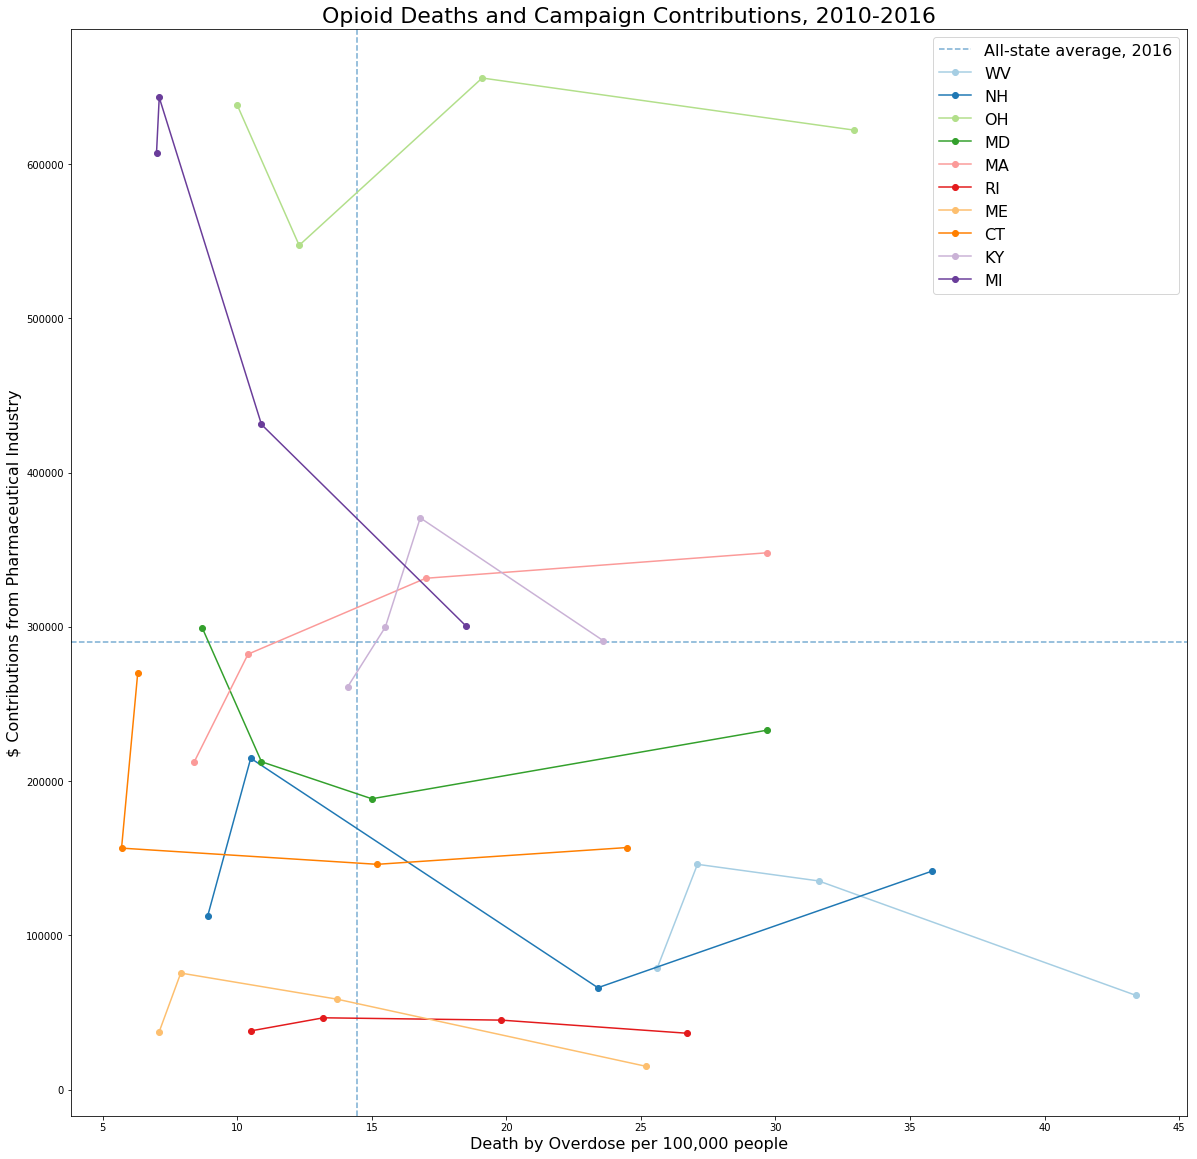

In [78]:
#Base graphic (blue dots)
# ax = overdoses_expenditures.plot.scatter(
#     x="Age Adjusted Rate",
#     y="Total Expenditures", 
#     figsize=(20,20)
# )

#Select top 10 states by overdose in 2016
top_states = overdoses_expenditures.loc[
    overdoses_expenditures['Year'] == 2016
].nlargest(10, 'Age Adjusted Rate')
top_states

#Create figure, plot mean values
fig = plt.figure(figsize=(20,20))
mean_overdose_rate = overdoses_expenditures.loc[overdoses_expenditures["Year"] == 2016]["Age Adjusted Rate"].mean()
mean_expenditure = overdoses_expenditures.loc[overdoses_expenditures["Year"] == 2016]["Total Expenditures"].mean()
plt.axvline(
    mean_overdose_rate,
    linestyle='dashed',
    linewidth=1.5,
    alpha=.6,
    label="All-state average, 2016"
)
plt.axhline(mean_expenditure, linestyle='dashed', linewidth=1.5, alpha=.6)

#color in and connect dots for top states
import seaborn as sns
colors = sns.color_palette("Paired", 10)
color_counter = 0
for state in top_states["State"]:
    x = overdoses_expenditures[
        overdoses_expenditures['State'] == state
    ].sort_values('Year')['Age Adjusted Rate']
    y = overdoses_expenditures[
        overdoses_expenditures['State'] == state
    ].sort_values('Year')['Total Expenditures']
    #for i in range(len(x)-1):
    plt.plot(
        x,
        y,
        'o-',
        color=colors[color_counter],
        label=state
         #alpha=alphas[alphas_counter]
    )
    color_counter += 1
plt.title("Opioid Deaths and Campaign Contributions, 2010-2016", fontdict={'fontsize':22})
plt.xlabel("Death by Overdose per 100,000 people", fontsize=16)
plt.ylabel("$ Contributions from Pharmaceutical Industry", fontsize=16)
plt.legend(fontsize=16)
plt.show()

OK, something is seriously weird. When opioid overdoses are very high, the industry tends not to be very reactive to fluctuations in overdose rates; at lower rates, they're all over the place. Look at all the places where the increase in overdoses year-over-year has slowed or started to reverse, and how contributions jumped all of a sudden.

The ones we'll have to look out for are Michigan, Ohio, New Hampshire, Connecticut and Massachusetts.